# Overview

This notebook handles creating state-specific data for 2020 precinct geogrpahic data, 2020 US House of Representative election data, and 2020 Census population estimates. While the exact steps for each state vary, the overall scheme is that the precinct data is collected from the [Redistricting Data Hub](https://redistrictingdatahub.org/) (RDH), voting data is collected is from either RDH or [Voting and Elections Science Team](https://dataverse.harvard.edu/dataverse/electionscience), and the population is gathered from the [Census Bureau](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=Blocks+%282020%29).

The general process is:
1. Load in the precinct shapefile
2. Change the projection to an applicable (ftUS) projection based on state
3. Prepare the House of Representatives Voting Data By:
   1. If the House Voting data is already attached to the precinct shapefile, aggregate it to Democract/Republican totals per precinct
   2. If not load ,in the voting data from another file and aggregate the House Votes and attempt to join the data by using a combination of the metadata available
   3. If the latter, there may be some data cleaning and manual work required to merge the datasets, such as creating a concatenation of columns or using a self-created crosswalk, aggregating precincts in the voting data, etc.
4. Load in the Census Block  and project it to the correspoding projection above
5. Use [MGGG](https://github.com/mggg/maup)'s `maup` package to assign blocks to precincts and aggregate (sum) by assignment
6. Plot out a fitline between population and vote count to observe any oddities
7. Write out data to disk

Not every state has been completed due to issues in trying to connect the precinct and voting data and additionally assumptions were made when joining the data (either programmatically or manually) that may not be correct which could result in precincts being assigned the wrong votes or population counts. There is also a concern that the underlying data may not be entirely accurate and could cause deviations from reveal life numbers. 

Originally, the plan was to incorporate 2022 data but it became an intractable option as there have been new voting precincts and voting data that either don't align correctly with existing data or that data is not readily available for use. 

# Data Table

This table records what data is available as of March 2023 and at what level.

| State | Districts | VEST/MEDSL 2020 | MEDSL2022 | RDH 2020 | RDH 2022 | Completed |
| --- | --- | --- | --- | --- | --- | --- |
| Alabama | | House | House | House | | 
| Alaska | | House | House | Pres | | 
| Arizona | | House |  | House | | |
| Arkansas | | House |  |  Pres | | 
| California | | House |  | Pres | | 
| Colorado | | House |  | Pres | | 
| Connecticut | | House |  | Pres | | 
| Delaware | | House |  | Pres | | 
| District of Columbia | | House | House | |
| Florida | | House | House | House | | |
| Georgia | | House | House | House | House-Vote | |
| Hawaii | | House | House | Pres |  | |
| Idaho | | House | House | Pres | | |
| Illinois | | House |  | Pres | | |
| Indiana | | House | House | Pres | | |
| Iowa | | House | House | Pres | | |
| Kansas | | House | House | Pres | | |
| Kentucky | | House | House | Pres | | 
| Louisiana | | House | House | Pres | House | 
| Maine | | House | House | Pres | | |
| Maryland | | House | House | Pres | | |
| Massachusetts | | House | House | Pres | | |
| Michigan | | House | House | House | | 
| Minnesota | | House | House | Pres | | 
| Mississippi | | House | House | House | | |
| Missouri | | House |  | Pres | | |
| Montana | | House |  | Pres | | |
| Nebraska | | House |  | Pres | | |
| Nevada | | House | House | Pres | | 
| New Hampshire | | House | House | Pres | | Yes |
| New Jersey | | House | House | Pres | | 
| New Mexico | | House | House | Pres | | |
| New York | | House |  | Pres | | 
| North Carolina | | House | House | House | | |
| North Dakota | |  | House | Pres | | |
| Ohio | | House | House | House | House-Vote | |
| Oklahoma | | House | House | Pres | | |
| Oregon | | House | | Pres | | |
| Pennsylvania | | House | | House | | 
| Rhode Island | | House | House | Pres | | |
| South Carolina | | House | House | Pres | | |
| South Dakota | | House | House | Pres | | |
| Tennesse | | House | House | Pres | | |
| Texas | | House |  | Pres | | |
| Utah | | House |  | Pres | | |
| Vermont | | House | House | Pres | | |
| Virginia | | House | House | House | | |
| Washington | | House | House | Pres | | |
| West Virginia | | House | House | Pres | | 
| Wisconsin | | House |  | House | | |
| Wyoming | | House | House | Pres | | |

# Packages and User Functions

In [16]:
import os
import re
import math
import matplotlib.pyplot as plt
import warnings

import numpy as np
import scipy
import shapely  # must be >=1.8.0
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Polygon, MultiPolygon, shape, Point, GeometryCollection

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

import pandas as pd
import geopandas as gpd

gpd.options.use_pygeos = False

import maup

In [17]:
def create_fitline(x, y):
    """
    Learns a linear regression and prints out the fitline, mainly to observe the correlation between population and vote counts.
    """
    # y = m + bx
    xlim = (min(x), max(x))
    res = scipy.stats.linregress(x, y)
    print(f"R-squared: {res.rvalue**2:.6f}")

    plot_x = np.linspace(start=xlim[0], stop=xlim[1], num=3)
    plt.scatter(x, y, s=2, label="original data")
    plt.plot(plot_x, res.intercept + res.slope * plot_x, "r", label="fitted line")
    plt.legend()
    plt.show()


def sum_cols(x, cols):
    """
    Sum values across a provided list of columns.
    """
    sum_ = 0
    for c in cols:
        sum_ += x[c]
    return sum_


def convert_3D_2D(x):
    """
    Takes a GeoSeries of 3D Multi/Polygons (has_z) and returns a list of 2D Multi/Polygons
    """
    return shapely.validation.make_valid(
        shapely.wkb.loads(shapely.wkb.dumps(x, output_dimension=2))
    )


def remove_geom_collections(x):
    """
    Geopandas errors on writing out mixed (Polygon/MultiPolygon and GeometryCollection) geometric types.
    The 3D --> 2D function can introduce GeometryCollections and so this function takes the first item within the collection.
    """

    if type(x) == GeometryCollection:
        return x.geoms[0]
    else:
        return x

# States

In [65]:
state_dict = {
    "GA": {"CRS": "EPSG:2240"},
    "MD": {"CRS": "EPSG:2248"},
    "NH": {"CRS": "EPSG:3437"},
    "OH": {"CRS": "EPSG:2834"},
}

## Alabama

## Alaska

## Arizona

## Arkansas

## California

## Colorado

## Connecticut

## Delaware

## Florida

## Georgia

In [30]:
ga_2020 = gpd.read_file(
    "input/ga/ga_gen_20_prec/ga_gen_20_cong_prec.shp"
)  # https://redistrictingdatahub.org/dataset/georgia-2020-general-election-precinct-and-election-results-extended/
ga_2020 = ga_2020.to_crs(state_dict["GA"]["CRS"])
ga_2020["geometry"] = ga_2020["geometry"].apply(shapely.validation.make_valid)
ga_2020["geometry"] = ga_2020["geometry"].apply(convert_3D_2D)
ga_2020["geometry"] = ga_2020["geometry"].apply(remove_geom_collections)

dem_votes = [c for c in ga_2020.columns if bool(re.match("GCON[0-9][0-9]D", c))]
rep_votes = [c for c in ga_2020.columns if bool(re.match("GCON[0-9][0-9]R", c))]

ga_2020["USH20_D"] = ga_2020.apply(sum_cols, cols=dem_votes, axis=1)
ga_2020["USH20_R"] = ga_2020.apply(sum_cols, cols=rep_votes, axis=1)

ga_2020 = ga_2020[
    [
        "UNIQUE_ID",
        "COUNTYFP",
        "DISTRICT",
        "CTYSOSID",
        "PRECINCT_I",
        "PRECINCT_N",
        "CTYNAME",
        "CTYNUMBER",
        "CTYNUMBER2",
        "FIPS2",
        "CONG_DIST",
        "USH20_D",
        "USH20_R",
        "geometry",
    ]
]
ga_2020.sample(n=3)

,UNIQUE_ID,COUNTYFP,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER,CTYNUMBER2,FIPS2,CONG_DIST,USH20_D,USH20_R,geometry
1375,121-JC03A,121,121JC03A,121JC03A,JC03A,JC03A,FULTON,60,060,121,06,281,199,"POLYGON ((2289710.240 1480035.744, 2289715.091..."
1250,121-08P,121,12108P,12108P,08P,08P,FULTON,60,060,121,05,895,227,"POLYGON ((2223363.068 1378199.439, 2223344.050..."
24,009-EAST HARDWICK,009,009321E,009321E,321E,EAST HARDWICK,BALDWIN,5,005,009,10,497,141,"MULTIPOLYGON (((2593559.280 1112338.090, 25935..."


In [31]:
ga_cb = gpd.read_file(
    "input/ga/tl_2020_13_tabblock20/"
)  # https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=Blocks+%282020%29
print(ga_cb.shape)
ga_cb = ga_cb.to_crs(ga_2020.crs)
ga_cb["geometry"] = ga_cb["geometry"].apply(shapely.validation.make_valid)
assignment = maup.assign(ga_cb, ga_2020)
ga_2020["POP20"] = ga_cb[["POP20"]].groupby(assignment).sum()

(232717, 18)


R-squared: 0.840730


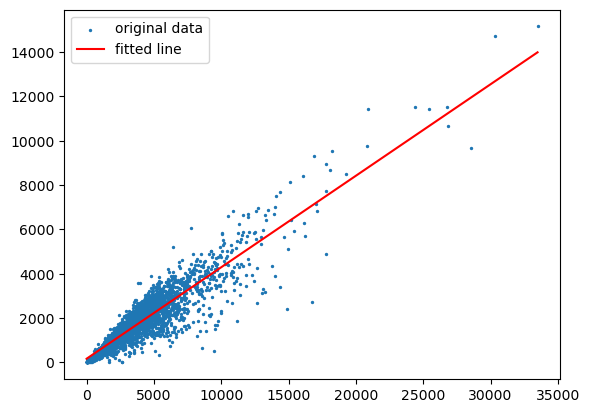

In [32]:
cols_to_fill = ["POP20", "USH20_D", "USH20_R"]
for c in cols_to_fill:
    ga_2020[c] = ga_2020[c].fillna(0)
create_fitline(ga_2020["POP20"], ga_2020["USH20_D"] + ga_2020["USH20_R"])

In [33]:
os.makedirs("output/ga_2020/", exist_ok=True)
ga_2020.to_file("output/ga_2020/ga_2020.shp")

## Hawaii

## Idaho

## Illinois

## Indiana

## Iowa

## Kansas

## Kentucky

## Louisiana

## Maine

## Maryland

In [19]:
# 2010-2020 MD Precincts
# md_2020_prec = gpd.read_file("../../data/mggg-states/MD/MD-precincts_abs.shp")
md_2020_prec = gpd.read_file(
    "input/md/md_vest_20/"
)  # https://redistrictingdatahub.org/dataset/vest-2020-maryland-precinct-and-election-results/
print(md_2020_prec.shape)
md_2020_prec = md_2020_prec.to_crs(state_dict["MD"]["CRS"])


# 2020 MD Voting from VEST
md_2020_votes = pd.read_csv("input/HOUSE_precinct_general.csv")
md_2020_votes = md_2020_votes.loc[md_2020_votes["state"] == "MARYLAND"]


# 2020 Census
md_cb = gpd.read_file(
    "input/md/tl_2020_24_tabblock20/"
)  # https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2020&layergroup=Blocks+%282020%29

(2043, 11)


In [20]:
md_2020_votes = md_2020_votes.loc[md_2020_votes["state"] == "MARYLAND"]
md_2020_votes = md_2020_votes.loc[md_2020_votes["office"] == "US HOUSE"]
md_2020_votes = md_2020_votes.loc[
    md_2020_votes["party_simplified"].isin(["DEMOCRAT", "REPUBLICAN"])
]
md_2020_votes["precinct_"] = md_2020_votes.apply(
    lambda x: x["jurisdiction_name"] + " PRECINCT " + x["precinct"], axis=1
)
md_2020_votes_only = (
    md_2020_votes.groupby(["precinct_", "party_simplified"])["votes"]
    .sum()
    .reset_index()
)
md_2020_votes_only = md_2020_votes_only.pivot(
    index="precinct_", columns="party_simplified", values="votes"
).reset_index()
md_2020_votes_only.columns = ["precinct_", "USH20_D", "USH20_R"]
print(md_2020_votes_only.shape)
md_2020_votes_only.sample(n=2)

(2035, 3)


,precinct_,USH20_D,USH20_R
433,BALTIMORE CITY PRECINCT 26-018,585,36
1350,MONTGOMERY PRECINCT 06-004,1434,421


In [21]:
## Manually prepared excel file to connect the RDH and VEST datasets
md_map = pd.read_excel("input/md/md_map.xlsx")
md_2020_votes_only = md_2020_votes_only.merge(md_map, on="precinct_")
print(md_2020_votes_only.shape)
md_2020_votes_only.sample(n=3)
md_2020 = md_2020_prec.merge(
    md_2020_votes_only, how="left", left_on="NAME", right_on="match"
)

(2035, 4)


In [22]:
md_2020["geometry"] = md_2020["geometry"].apply(shapely.validation.make_valid)
md_2020["geometry"] = md_2020["geometry"].apply(convert_3D_2D)
md_2020["geometry"] = md_2020["geometry"].apply(remove_geom_collections)

In [23]:
print(md_cb.shape)
md_cb = md_cb.to_crs(md_2020.crs)
md_cb["geometry"] = md_cb["geometry"].apply(shapely.validation.make_valid)
assignment = maup.assign(md_cb, md_2020)
md_2020["POP20"] = md_cb[["POP20"]].groupby(assignment).sum()

(83827, 18)


R-squared: 0.752542


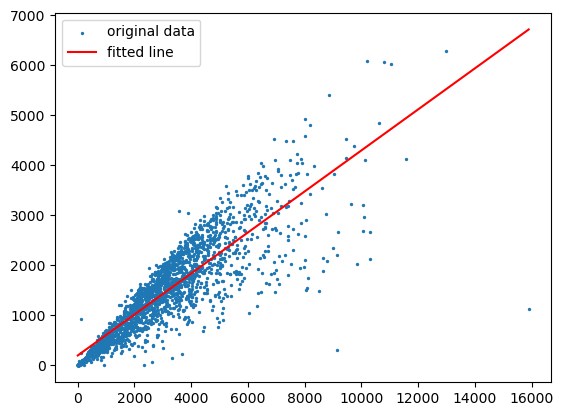

In [24]:
cols_to_fill = ["POP20", "USH20_D", "USH20_R"]
for c in cols_to_fill:
    md_2020[c] = md_2020[c].fillna(0)
create_fitline(md_2020["POP20"], md_2020["USH20_D"] + md_2020["USH20_R"])

In [25]:
os.makedirs("output/md_2020/", exist_ok=True)
md_2020.to_file("output/md_2020/md_2020.shp")

## Massachusetts

## Michigan

## Minnesota

## Mississippi

## Missouri

## Montana

## Nebraska

## Nevada

## New Hampshire

In [12]:
# 2020 Precict Boundaries and Housing Voting Data
nh_2020 = gpd.read_file(
    "../../data/mggg-states/nh/"
)  # https://github.com/mggg-states/NH-shapefiles
print(nh_2020.shape)
nh_2020 = nh_2020.to_crs(state_dict["NH"]["CRS"])
nh_2020["geometry"] = nh_2020["geometry"].apply(convert_3D_2D)
# 2022 House Voting
nh_2022_votes = pd.read_csv(
    "input/nh/nh22_cleaned.csv"
)  # https://github.com/MEDSL/2022-elections-official
# 2020 Census Blocks Shapefile with Population Estimates
nh_cb = gpd.read_file(
    "input/nh/tl_2020_33_tabblock20/"
)  # https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2020&layergroup=Blocks+%282020%29

(320, 71)


<Axes: >

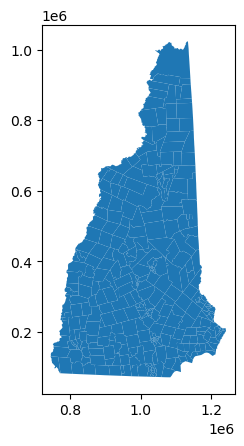

In [13]:
nh_2020.plot()

In [14]:
nh_2020.columns = [
    c[:-1] + "_" + c[-1] if c.startswith("USH20") else c for c in nh_2020.columns
]

In [15]:
def cleaner(df, house_office="US HOUSE"):
    df_ = df.copy()
    df_ = df_.loc[df_["office"] == house_office]
    df_ = df_.loc[df_["party_simplified"].isin(["DEMOCRAT", "REPUBLICAN"])]
    df_votes = (
        df_.groupby(["precinct", "party_simplified"])["votes"].sum().reset_index()
    )
    return df_votes


nh_2022_votes_only = cleaner(nh_2022_votes)
nh_2022_votes_only = nh_2022_votes_only.pivot(
    index="precinct", columns="party_simplified", values="votes"
).reset_index()
nh_2022_votes_only.columns = ["precinct", "USH22_D", "USH22_R"]

In [16]:
def renamer(s):
    if s == "Atkinson & Gilmanton - Entire":
        return "ATKINSON AND GILMANTON ACADEMY GRANT"
    if s == "Low & Burbanks Grant - Entire":
        return "LOW AND BURBANK'S GRANT"
    if s == "Thompson & Meserve - Entire":
        return "THOMPSON AND MESERVE'S PURCHASE"
    if s.endswith(" - Entire"):
        return s[: len(s) - len(" - Entire")].upper()
    else:
        s = s.upper()
        s_p = s.split("- ")
        s = s_p[0] + s_p[1]
        return s


nh_2020["precinct"] = nh_2020["Precinct"].apply(renamer)
nh_2020 = nh_2020.merge(nh_2022_votes_only, on="precinct", how="left")
print(nh_2020.shape)

(320, 74)


In [17]:
print(nh_cb.shape)
print("Converting CRS")
nh_cb = nh_cb.to_crs(state_dict["NH"]["CRS"])
nh_cb["geometry"] = nh_cb["geometry"].apply(shapely.validation.make_valid)
print("Assigning Census Blocks")
assignment = maup.assign(nh_cb, nh_2020)
nh_2020["POP20"] = nh_cb[["POP20"]].groupby(assignment).sum()

(31948, 18)
Converting CRS
Assigning Census Blocks


R-squared: 0.958947


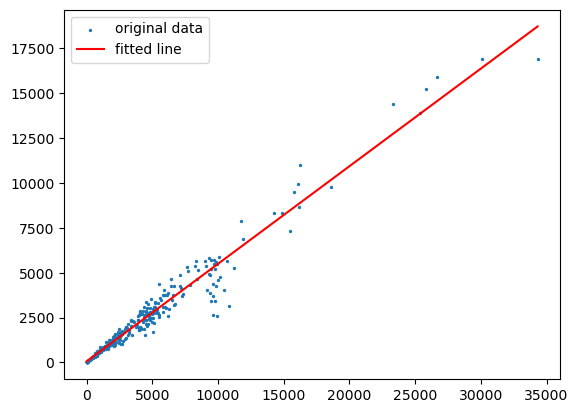

In [18]:
cols_to_fill = ["POP20", "USH20_D", "USH20_R"]
for c in cols_to_fill:
    nh_2020[c] = nh_2020[c].fillna(0)
create_fitline(nh_2020["POP20"], nh_2020["USH20_D"] + nh_2020["USH20_R"])

In [19]:
os.makedirs("output/nh_2020/", exist_ok=True)
nh_2020.to_file("output/nh_2020/nh_2020.shp")

## New Jersey

## New Mexico

## New York

## North Carolina

## North Dakota

## Ohio

(8941, 23)
R-squared: 0.382879


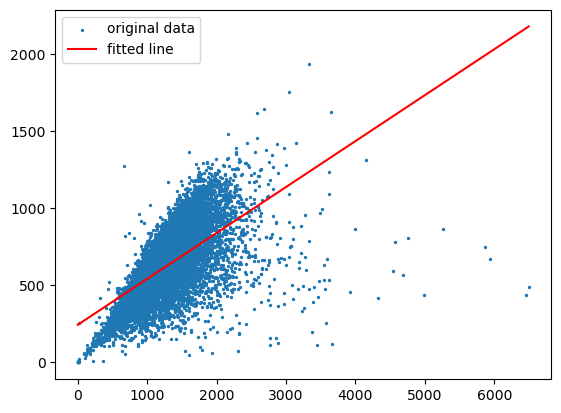

C:\Users\yagne\AppData\Local\Temp\ipykernel_568\2643239868.py:58: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  oh_2020_2022.to_file("output/oh_2020/oh_2020.shp")


In [66]:
oh_2020 = gpd.read_file(
    "input/oh/oh_gen_20_prec/oh_gen_20_prec/oh_gen_20_cong_prec.shp"
)
oh_2020 = oh_2020.to_crs(state_dict["OH"]["CRS"])
dem_votes = [c for c in oh_2020.columns if bool(re.match("GCON[0-9][0-9]D", c))]
rep_votes = [c for c in oh_2020.columns if bool(re.match("GCON[0-9][0-9]R", c))]
oh_2020["USH20_D"] = oh_2020.apply(sum_cols, cols=dem_votes, axis=1)
oh_2020["USH20_R"] = oh_2020.apply(sum_cols, cols=rep_votes, axis=1)

oh_2020 = oh_2020[
    [
        "UNIQUE_ID",
        "COUNTYFP",
        "STATEFP20",
        "COUNTYFP20",
        "VTDST20",
        "PRECINCT20",
        "GEOID20",
        "CONG_DIST",
        "geometry",
        "USH20_D",
        "USH20_R",
    ]
]


def id_formatter(s):
    s = re.sub(r"-\(CON-[0-9]+\)", "", s)
    return s


def join_text(x):
    return "|".join(x)


oh_2020["ID"] = oh_2020["UNIQUE_ID"].apply(id_formatter)
oh_2020 = oh_2020.dissolve(
    by="ID",
    aggfunc={
        "UNIQUE_ID": join_text,
        "COUNTYFP": "first",
        "STATEFP20": "first",
        "COUNTYFP20": "first",
        "VTDST20": "first",
        "PRECINCT20": "first",
        "GEOID20": "first",
        "CONG_DIST": join_text,
        "USH20_D": "sum",
        "USH20_R": "sum",
    },
).reset_index()

oh_2022 = pd.read_csv("input/oh/oh_2022_gen_prec/oh_2022_gen_prec.csv")
dem_votes = [c for c in oh_2022.columns if bool(re.match("GCON[0-9][0-9]D", c))]
rep_votes = [c for c in oh_2022.columns if bool(re.match("GCON[0-9][0-9]R", c))]

oh_2022["USH22_D"] = oh_2022.apply(sum_cols, cols=dem_votes, axis=1)
oh_2022["USH22_R"] = oh_2022.apply(sum_cols, cols=rep_votes, axis=1)
oh_2022 = oh_2022[
    [
        "UNIQUE_ID",
        "COUNTYFP",
        "County",
        "PRECNAME",
        "PRECCODE",
        "Region",
        "Market",
        "REGVOT",
        "BALLOTS",
        "USH22_D",
        "USH22_R",
    ]
]


def id_formatter(x):
    return str(x["COUNTYFP"]).zfill(3) + "-" + x["PRECCODE"]


oh_2022["ID"] = oh_2022.apply(id_formatter, axis=1)

oh_2020_2022 = oh_2020.merge(oh_2022, on="ID", how="left")
print(oh_2020_2022.shape)

oh_cb = gpd.read_file("input/oh/tl_2022_39_tabblock20/")

oh_cb = oh_cb.to_crs(oh_2020_2022.crs)
assignment = maup.assign(oh_cb, oh_2020_2022)
oh_2020_2022["POP20"] = oh_cb[["POP20"]].groupby(assignment).sum()

oh_2020_2022.columns
cols_to_fill = ["POP20", "USH20_D", "USH20_R", "USH22_D", "USH22_R"]
for c in cols_to_fill:
    oh_2020_2022[c] = oh_2020_2022[c].fillna(0)

create_fitline(oh_2020_2022["POP20"], oh_2020_2022["USH20_R"] + oh_2020_2022["USH20_D"])

os.makedirs("output/oh_2020/", exist_ok=True)
oh_2020_2022.to_file("output/oh_2020/oh_2020.shp")

## Oklahoma

## Oregon

## Pennsylvania

## Rhode Island

## South Carolina

## South Dakota

## Tennessee

## Texas

## Utah

## Vermont

## Virginia

## Washington

## West Virginia

## Wisconsin

## Wyoming